# Forcasting  

In this notebook we will predict the closing prices for the next month

In [200]:
# Import Libraries
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import datetime


In [201]:
with open('/Users/yasminezaatour/Desktop/tunisia-stock-market/stock_scraper/companies_data/AB.json') as f:
    data = json.load(f)

data = pd.json_normalize(data, 'QuoteTab', ['Name'])

# Rename the columns
data.rename(columns={
    'Name': 'companyName',
    'd': 'date',
    'o': 'openingPrice',
    'h': 'highestPrice',
    'l': 'lowestPrice',
    'c': 'closingPrice',
    'v': 'volume'
}, inplace=True)
data

,date,openingPrice,highestPrice,lowestPrice,closingPrice,volume,companyName
0,09/06/2014,23.63,23.63,22.75,23.14,1608,AMEN BANK
1,16/06/2014,23.63,23.63,22.75,23.14,1608,AMEN BANK
2,23/06/2014,23.14,23.14,22.37,22.75,16837,AMEN BANK
3,30/06/2014,22.75,22.97,22.07,22.66,33514,AMEN BANK
4,07/07/2014,22.75,23.17,21.88,22.74,3340,AMEN BANK
...,...,...,...,...,...,...,...
518,13/05/2024,40.00,41.12,39.50,39.99,99239,AMEN BANK
519,20/05/2024,39.99,41.12,39.99,40.90,44343,AMEN BANK
520,27/05/2024,40.95,41.50,40.42,41.18,46829,AMEN BANK
521,03/06/2024,41.18,42.00,41.00,42.00,24726,AMEN BANK


In [202]:
df = data[['date','closingPrice']]
df

,date,closingPrice
0,09/06/2014,23.14
1,16/06/2014,23.14
2,23/06/2014,22.75
3,30/06/2014,22.66
4,07/07/2014,22.74
...,...,...
518,13/05/2024,39.99
519,20/05/2024,40.90
520,27/05/2024,41.18
521,03/06/2024,42.00


In [203]:
df['date']

0      09/06/2014
1      16/06/2014
2      23/06/2014
3      30/06/2014
4      07/07/2014
          ...    
518    13/05/2024
519    20/05/2024
520    27/05/2024
521    03/06/2024
522    10/06/2024
Name: date, Length: 523, dtype: object

In [204]:
def str_to_datetime (s):
    split = s.split('/')
    day, month, year = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('16/06/2014')
datetime_object

datetime.datetime(2014, 6, 16, 0, 0)

In [205]:
df['date'] = df['date'].apply(str_to_datetime)
df['date']

/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_94885/3235390050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


0     2014-06-09
1     2014-06-16
2     2014-06-23
3     2014-06-30
4     2014-07-07
         ...    
518   2024-05-13
519   2024-05-20
520   2024-05-27
521   2024-06-03
522   2024-06-10
Name: date, Length: 523, dtype: datetime64[ns]

In [206]:
df.index = df.pop('date')
df

,closingPrice
date,
2014-06-09,23.14
2014-06-16,23.14
2014-06-23,22.75
2014-06-30,22.66
2014-07-07,22.74
...,...
2024-05-13,39.99
2024-05-20,40.90
2024-05-27,41.18


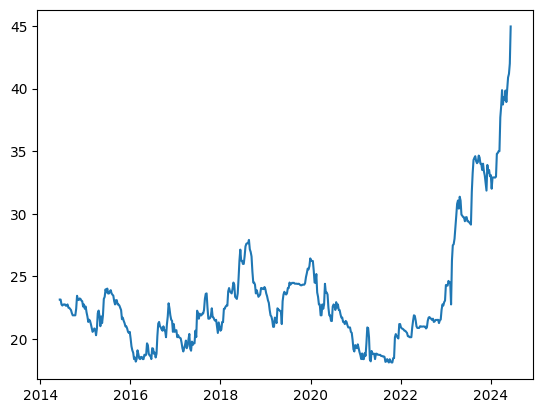

In [207]:
plt.plot(df.index, df['closingPrice'])

*We will use the LSTM (Long Short Term Memory) model, we need to convert this into a supervised learning problem.*


In [208]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['closingPrice'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '30/06/2014', 
                                '10/06/2024', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2014-06-30,23.14,23.14,22.75,22.66
1,2014-07-07,23.14,22.75,22.66,22.74
2,2014-07-14,22.75,22.66,22.74,22.75
3,2014-07-21,22.66,22.74,22.75,22.75
4,2014-07-28,22.74,22.75,22.75,22.65
...,...,...,...,...,...
515,2024-05-13,39.10,39.85,38.93,39.99
516,2024-05-20,39.85,38.93,39.99,40.90
517,2024-05-27,38.93,39.99,40.90,41.18
518,2024-06-03,39.99,40.90,41.18,42.00


*Processing windowed_df for TensorFlow Model Training*

In [209]:
def windowed_df_to_date_X_y(windowed_df):
    df_as_np = windowed_df.to_numpy()

    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape(len(dates),middle_matrix.shape[1],1)
    y= df_as_np[:, -1]
    return dates, X.astype(np.float32), y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

 

((520,), (520, 3, 1), (520,))